pip install transformers sentence-transformers

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Bert and TSNE 
https://github.com/mcelikkaya/medium_articles2/blob/main/bertlda_topic_modeling.ipynb 

In [115]:
import torch
from transformers import BertTokenizer, BertModel
import logging
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap
import numpy as np
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import Counter

'''
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
'''
model_bert = SentenceTransformer('bert-base-nli-max-tokens')                             

In [6]:
df_summary = pd.read_csv("/content/gdrive/MyDrive/Group-1-Project/data and algorithm/Book_summary.csv")
df_summary

,Unnamed: 0,Book-Title,Book-Author_x,Book-Summary,ISBN
0,0,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",345316413X
1,1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",0749318473
2,2,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",0345256328
3,3,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",0345273214
4,4,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",3453130790
...,...,...,...,...,...
13782,13783,Remote Control,Andy McNab,The series follows the character of Nick Ston...,0451191692
13783,13784,Remote Control,Andy McNab,The series follows the character of Nick Ston...,0345254457
13784,13785,The Simpsons: A Complete Guide to Our Favorite...,Matt Groening,"{| class=""wikitable"" |- !Seasons covered !Boo...",0060952520
13785,13786,Transfer of Power,Vince Flynn,The reader first meets Rapp while he is doing...,0671023209


In [7]:
def tokenize_text(text):
  marked_text = "[CLS] " + text + " [SEP]"
  # Split the sentence into tokens.
  tokenized_text = tokenizer.tokenize(marked_text)

  # Map the token strings to their vocabulary indeces.
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

  segments_ids = [1] * len(tokenized_text)

  #print(len(tokenized_text), " in total")

  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  return tokenized_text, tokens_tensor, segments_tensors

In [103]:
def paragraph_to_vec_2(text):
  embedding_bert = model_bert.encode(text)
  return embedding_bert

In [104]:
def all_books_to_vecs(books):
  embedding_bert = np.array(model_bert.encode(books))
  return embedding_bert

In [108]:
def reduce_tsne(embedding):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform( embedding )
    
    return reduced

def predict_topics_with_kmeans(embeddings,num_topics):
  kmeans_model = KMeans(num_topics)
  kmeans_model.fit(embeddings)
  topics_labels = kmeans_model.predict(embeddings)
  return topics_labels


In [117]:
all_summary_list = df_summary.head(1000)["Book-Summary"].tolist()
all_summary_embeddings = all_books_to_vecs(all_summary_list)
all_summary_embeddings.shape

(1000, 768)

In [118]:
num_topics = 4
embedding_bert_tsne =  reduce_tsne(all_summary_embeddings)
labels_bert_tsne  = predict_topics_with_kmeans(embedding_bert_tsne,num_topics)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


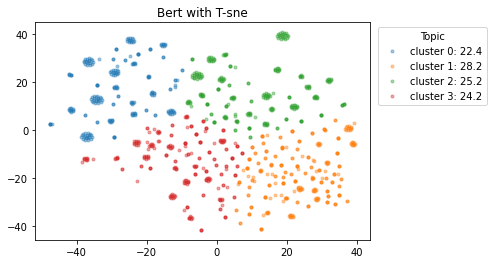

In [119]:
def plot_embeddings(embedding, labels,title):

    labels = np.array( labels )
    distinct_labels =  set( labels )
    
    n = len(embedding)
    counter = Counter(labels)
    for i in range(len( distinct_labels )):
        ratio = (counter[i] / n )* 100
        cluster_label = f"cluster {i}: { round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.legend(title="Topic",loc = 'upper left', bbox_to_anchor=(1.01,1))
    plt.title(title)
    
plot_embeddings(embedding_bert_tsne,labels_bert_tsne,"Bert with T-sne")

In [76]:
def paragraph_to_vec_1(text): #Extremely slow
  text_segments = wrap(text, 510)
  paragraph_vec = []
  for text_segment in text_segments:
    tokenized_text, tokens_tensor, segments_tensors = tokenize_text(text_segment)
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    for token_vec in token_vecs:
      paragraph_vec.append(token_vec.detach().numpy().squeeze())
    #print(token_vecs.shape)
  print(len(paragraph_vec), len(paragraph_vec[0]))

  return paragraph_vec

In [12]:
text= 'With probability 0.5, sentence A and sentence B correspond to two consecutive sentences in the original corpus'
text_vec = paragraph_to_vec(text)
text_vec.shape, text_vec

(torch.Size([22, 768]),
 tensor([[-0.4069, -0.7221, -0.0961,  ..., -0.2900,  0.1349,  1.0193],
         [-0.5965,  0.3097,  0.1628,  ..., -1.1278, -0.4784,  0.6773],
         [ 0.6815, -0.4608,  0.3712,  ..., -0.2719,  0.4671, -0.0047],
         ...,
         [ 0.0075, -0.7058, -0.0161,  ..., -0.2170,  0.4222,  0.2408],
         [-0.9343, -1.0692, -0.4720,  ...,  0.3368,  0.4610,  0.4058],
         [ 0.0541,  0.0045, -0.0298,  ...,  0.0214, -0.0353,  0.0209]],
        grad_fn=<SelectBackward0>))

In [95]:

for index, row in df_summary.head(10).iterrows():
  text = row['Book-Summary']
  text_vec = paragraph_to_vec_2(text)

  #print(text_vec[0])
  #text_segment_len = [len(segment) for segment in text_segments]
  #print(text_segment_len)
  #print(len(text_vec))

In [35]:
for index, row in df_summary.head(3).iterrows():
  text = row['Book-Summary']
  #text_vec = paragraph_to_vec(text)
  text_segments = wrap(text, 510)
  text_segment_len = [len(segment) for segment in text_segments]
  print(len(text_segment_len), text_segment_len)
  #print(len(text_vec))

13 [506, 507, 508, 502, 507, 510, 509, 507, 509, 510, 509, 510, 15]
13 [506, 507, 508, 502, 507, 510, 509, 507, 509, 510, 509, 510, 15]
13 [506, 507, 508, 502, 507, 510, 509, 507, 509, 510, 509, 510, 15]
